In [1]:
from PIL import Image
from skimage.io import imread
from skimage.transform import rescale, resize
import tensorflow as tf
import os
import glob
import string
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras import applications
import keras
from keras.layers import Dense, Activation, Flatten, Conv2D,Conv3D, MaxPooling2D,MaxPooling3D,Dropout,BatchNormalization
from keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from binvox_rw import read_as_3d_array,read_as_coord_array
from sklearn.metrics import confusion_matrix
import seaborn as sn
from tqdm import tqdm

In [2]:
path = "ModelNet10_64_Binvox/"

# path = 'MCB-Nuts-64/'
category_list=os.listdir(path)
train_file_list=os.listdir(path + 'train')
test_file_list=os.listdir(path + 'test')
class_list = os.listdir(path + 'train')

In [3]:
class_list

['table',
 'night_stand',
 'desk',
 'sofa',
 'bathtub',
 'chair',
 'monitor',
 'toilet',
 'bed',
 'dresser']

In [4]:
list_of_train = glob.glob(path + "train/**/*.binvox")
list_of_test = glob.glob(path + "test/**/*.binvox")
print("Total number of train files " + str(len(list_of_train)) )#Total data
print("Total number of test files " + str(len(list_of_test)) )#Total data
print("Total Number of classes "+ str(len(class_list))) #Total classes

Total number of train files 3991
Total number of test files 908
Total Number of classes 10


In [5]:
list_of_train.sort()
list_of_test.sort()
class_list.sort()

In [6]:
Class_Dict = {}
for i in range(len(class_list)):
    Class_Dict[i] = class_list[i] 
Class_Dict

{0: 'bathtub',
 1: 'bed',
 2: 'chair',
 3: 'desk',
 4: 'dresser',
 5: 'monitor',
 6: 'night_stand',
 7: 'sofa',
 8: 'table',
 9: 'toilet'}

In [7]:
Y_list = []
list_of_classes = glob.glob(path + "train/**")
list_of_classes.sort()
for i, data in enumerate(list_of_classes,0):
    list_of_images_in_folder = glob.glob(data+"/*.binvox") 
    for j, files in enumerate(list_of_images_in_folder):
        Y_list.append(i)
            
y_train = np.asarray(Y_list)
y_train = y_train.reshape(-1,1)
y_train.shape        

(3991, 1)

In [8]:
Y_list = []
list_of_classes = glob.glob(path + "test/**")
list_of_classes.sort()
for i, data in enumerate(list_of_classes,0):
    list_of_images_in_folder = glob.glob(data+"/*.binvox") 
    for j, files in enumerate(list_of_images_in_folder):
        Y_list.append(i)
            
y_test = np.asarray(Y_list)
y_test = y_test.reshape(-1,1)
y_test.shape 

(908, 1)

In [9]:
import pprint

train_unique, train_counts = np.unique(y_train, return_counts=True)
test_unique, test_counts = np.unique(y_test, return_counts=True)
num_class = len(np.unique(y_train))
train_count = dict(zip(Class_Dict.values(), train_counts))
test_count = dict(zip(Class_Dict.values(), test_counts))
print('y_train')
pprint.pprint(train_count, width=1,sort_dicts=False)
print('\n y_test')
pprint.pprint(test_count, width=1,sort_dicts=False)

y_train
{'bathtub': 106,
 'bed': 515,
 'chair': 889,
 'desk': 200,
 'dresser': 200,
 'monitor': 465,
 'night_stand': 200,
 'sofa': 680,
 'table': 392,
 'toilet': 344}

 y_test
{'bathtub': 50,
 'bed': 100,
 'chair': 100,
 'desk': 86,
 'dresser': 86,
 'monitor': 100,
 'night_stand': 86,
 'sofa': 100,
 'table': 100,
 'toilet': 100}


In [10]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())

In [11]:
res = 64

X_train = np.zeros([len(y_train),res,res,res])
for i,each in enumerate(tqdm(list_of_train,0)):
            with open(each, 'rb') as f:
#                m1 = read_as_coord_array(f)
                    m1 = read_as_3d_array(f)
    #               X[i] = binvox_rw_py.dense_to_sparse(m1.data)
                    X_train[i] = m1.data
        
X_test = np.zeros([len(y_test),res,res,res])
for i,each in enumerate(tqdm(list_of_test,0)):
            with open(each, 'rb') as f:
#                m1 = read_as_coord_array(f)
                    m1 = read_as_3d_array(f)
    #               X[i] = binvox_rw_py.dense_to_sparse(m1.data)
                    X_test[i] = m1.data
                     
print('X_train ', X_train.shape)
print('X_test', X_test.shape)

100%|██████████| 908/908 [00:01<00:00, 502.75it/s]

X_train  (3991, 64, 64, 64)
X_test (908, 64, 64, 64)


[1]
bed


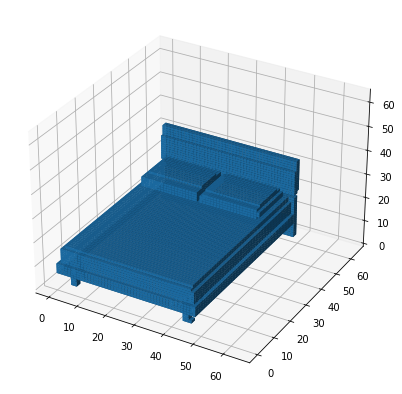

In [12]:
#For inspection
''' 
refer for Model Net 10
value counts

 indexes 
 {0: 'bathtub', 1: 'bed', 2: 'chair',
 3: 'desk', 4: 'dresser', 5: 'monitor',
 6: 'night_stand', 7: 'sofa', 8: 'table',
 9: 'toilet'}
 
 {'bathtub': 106, 'bed': 515, 'chair': 889,
 'desk': 200, 'dresser': 200, 'monitor': 465,
 'night_stand': 200, 'sofa': 680, 'table': 392,
 'toilet': 344}
 
for example 
idx = 105 should be bath_tub
idx = 106 should be bed

refer for MCB dataset
Indexes {0: 'Cap_nuts', 1: 'Castle_nuts', 2: 'Flange_nuts', 3: 'Hexagonal_nuts',
 4: 'Rivet_nuts', 5: 'Slotted_nuts', 6: 'Square_nuts', 7: 'T_nuts', 8: 'Wing_nuts'}
 
Counts {'Cap_nuts': 180,  'Castle_nuts': 132, 'Flange_nuts': 43, 'Hexagonal_nuts': 147,
 'Rivet_nuts': 41, 'Slotted_nuts': 63, 'Square_nuts': 43, 'T_nuts': 81, 'Wing_nuts': 40}}

for example 
idx = 80 T-nut
idx = 81 Flange-nut

'''
from mpl_toolkits import mplot3d
ax = plt.figure(figsize=(7,7)).add_subplot(projection='3d')

idx = 106
X_train = X_train.reshape(-1,res,res,res)
ax.voxels(X_train[idx])
print(y_train[idx])
print(Class_Dict[y_train[idx][0]])

In [13]:
X_train = X_train.reshape(-1,res,res,res,1) #(no.samples,l,b,h,no.channels)
X_test= X_test.reshape(-1,res,res,res,1)

In [14]:
Y_train_one_hot = to_categorical(y_train)
Y_test_one_hot = to_categorical(y_test)
print(Y_train_one_hot.shape)
print(Y_test_one_hot.shape)

(3991, 10)
(908, 10)


In [15]:
#Creation of a 3dCNN . Sequential Model
sample_shape = (res, res, res, 1)

model = Sequential()
model.add(Conv3D(64, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', 
                 input_shape=sample_shape))
model.add(Dropout(0.5))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())

model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.5))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Flatten())
model.add(Dense(16, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(num_class, activation='softmax'))
model.compile(loss=tf.keras.losses.categorical_crossentropy, 
              optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),metrics=['accuracy'])

2021-12-05 09:24:32.904088: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-05 09:24:35.780086: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9184 MB memory:  -> device: 0, name: GeForce RTX 2080 Ti, pci bus id: 0000:84:00.0, compute capability: 7.5
2021-12-05 09:24:35.781634: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9328 MB memory:  -> device: 1, name: GeForce RTX 2080 Ti, pci bus id: 0000:85:00.0, compute capability: 7.5
2021-12-05 09:24:35.782976: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 62, 62, 62, 2)     56        
                                                                 
 dropout (Dropout)           (None, 62, 62, 62, 2)     0         
                                                                 
 max_pooling3d (MaxPooling3D  (None, 31, 31, 31, 2)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 31, 31, 31, 2)    8         
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 29, 29, 29, 2)     110       
                                                                 
 dropout_1 (Dropout)         (None, 29, 29, 29, 2)     0

In [ ]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
no_epochs = 100
history = model.fit(X_train, Y_train_one_hot, batch_size=32, 
                    epochs = no_epochs,
#                     validation_split = 0.4,
                    validation_data=(X_test, Y_test_one_hot)
                   ) #Actual Training of model


Visible devices cannot be modified after being initialized


2021-12-05 09:24:45.384032: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4184866816 exceeds 10% of free system memory.
2021-12-05 09:24:50.233886: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4184866816 exceeds 10% of free system memory.


Epoch 1/100


2021-12-05 09:24:54.874467: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8101
2021-12-05 09:24:55.545901: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-12-05 09:24:55.546417: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-12-05 09:24:55.546487: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2021-12-05 09:24:55.552477: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2021-12-05 09:24:55.552647: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


125/125 [==============================] - 12s 73ms/step - loss: 2.3022 - accuracy: 0.2521 - val_loss: 2.2793 - val_accuracy: 0.1861
Epoch 2/100
125/125 [==============================] - 6s 45ms/step - loss: 2.1803 - accuracy: 0.3460 - val_loss: 2.2516 - val_accuracy: 0.1960
Epoch 3/100
125/125 [==============================] - 7s 52ms/step - loss: 2.1283 - accuracy: 0.3528 - val_loss: 2.2236 - val_accuracy: 0.1993
Epoch 4/100
125/125 [==============================] - 6s 45ms/step - loss: 2.0900 - accuracy: 0.3553 - val_loss: 2.2147 - val_accuracy: 0.1993
Epoch 5/100
125/125 [==============================] - 6s 49ms/step - loss: 2.0611 - accuracy: 0.3593 - val_loss: 2.1987 - val_accuracy: 0.2004
Epoch 6/100
125/125 [==============================] - 6s 45ms/step - loss: 2.0396 - accuracy: 0.3623 - val_loss: 2.1985 - val_accuracy: 0.1938
Epoch 7/100
125/125 [==============================] - 6s 50ms/step - loss: 2.0211 - accuracy: 0.3638 - val_loss: 2.1908 - val_accuracy: 0.1960
Epo

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,no_epochs)
plt.plot(epochs, loss_train[1:], 'g', label='Training loss')
plt.plot(epochs, loss_val[1:], 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

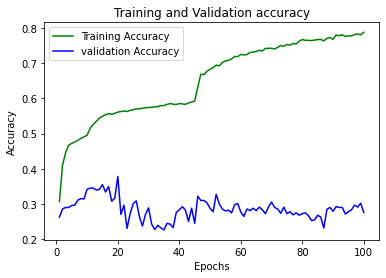

In [19]:
loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,no_epochs+1)
plt.plot(epochs, loss_train, 'g', label='Training Accuracy')
plt.plot(epochs, loss_val, 'b', label='validation Accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [20]:
predictions = model.predict(X_test,batch_size=64, verbose=0)
y_classes = predictions.argmax(axis=-1)
from sklearn.metrics import accuracy_score
print ('Test accuracy score is', accuracy_score(y_classes, y_test))

cm = confusion_matrix(y_test, y_classes)
print(cm)

Test accuracy score is 0.2753303964757709
[[ 0  0  0  0  0 15  0 12  4 19]
 [ 0  5  0  0  0 23  0 40 14 18]
 [ 0  0 49  0  0 37  6  0  7  1]
 [ 0  0  0  0  0 56  1  0 22  7]
 [ 0  0  0  0  0 72  0  0 14  0]
 [ 0  0  0  0  0 87  0  0  1 12]
 [ 0  0  1  0  1 49  1  0 32  2]
 [ 0  0  0  0  0  7  0  6  1 86]
 [ 0  1  0  0  0 86  0  0 10  3]
 [ 0  0  0  0  0  8  0  0  0 92]]


<AxesSubplot:>

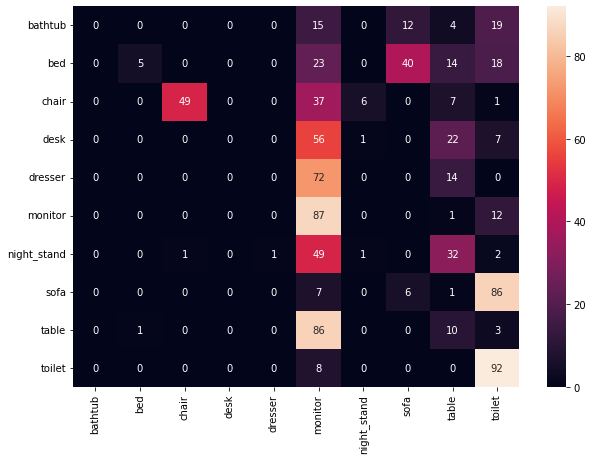

In [21]:
df_cm = pd.DataFrame(cm, index = [i for i in class_list],
                  columns = [i for i in class_list])
plt.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)